In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL.Image import fromarray
import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
paths = ['../input/kermany2018/OCT2017 /train/',
         '../input/kermany2018/OCT2017 /test/',
         '../input/kermany2018/OCT2017 /val/']

In [3]:
import os
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import img_to_array

In [4]:
def cvt_arr (impath) :
    return
def get_array (path) :    
    X = []
    y = []   
    for label, disease in enumerate(os.listdir(path)) :       
        # resize and append
        for count, image in enumerate(os.listdir(os.path.join(path, disease))) :
                X.append(img_to_array(
                   fromarray(
                       cv2.resize(cv2.cvtColor(
                           cv2.imread(
                               os.path.join(os.path.join(path, disease),image)),cv2.COLOR_BGR2GRAY),(32,32)))))         
                # only 5k imgs
                y.append(label)
                if count > 5e3 :
                    break
    X = np.array(X)
    y = np.array(y)
    return X/255.0, to_categorical(y)

In [5]:
X_train, y_train = get_array(paths[0])
print('training data extracted .....')
X_test , y_test  = get_array(paths[1])
print('testing data extracted ......')
X_valid, y_valid = get_array(paths[2])
print('validation data extracted ...')

training data extracted .....
testing data extracted ......
validation data extracted ...


In [6]:
print(X_train.shape)
print(y_train.shape)

(20008, 32, 32, 1)
(20008, 4)


In [7]:
print(X_test.shape)
print(y_test.shape)

(968, 32, 32, 1)
(968, 4)


In [8]:
print(X_valid.shape)
print(y_valid.shape)
print(X_train.min())
print(X_train.max())
print(y_train.min())
print(y_train.max())

(32, 32, 32, 1)
(32, 4)
0.0
1.0
0.0
1.0


In [9]:
import seaborn
import pandas

Text(0.5, 1.0, 'Test label distribution')

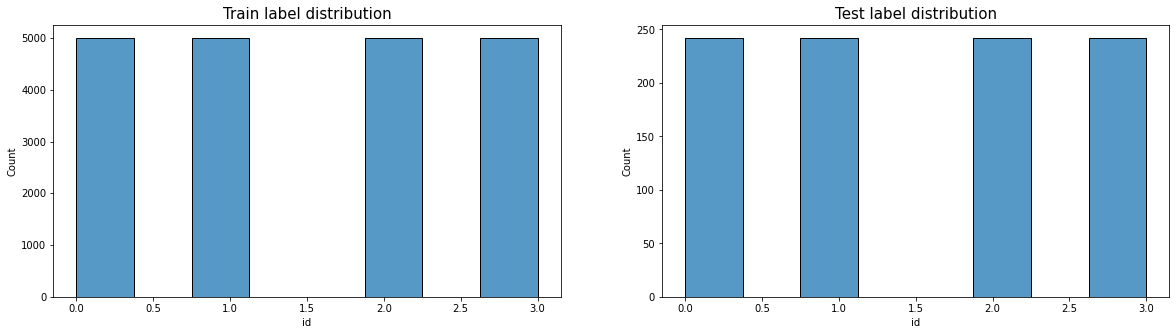

In [10]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
seaborn.histplot(data = pandas.DataFrame({'id' : np.argmax(y_train, axis = 1)}), x = 'id', bins = 8)
plt.title('Train label distribution', fontsize = 15)

plt.subplot(1,2,2)
seaborn.histplot(data = pandas.DataFrame({'id' : np.argmax(y_test , axis = 1)}), x = 'id', bins = 8)
plt.title('Test label distribution', fontsize = 15)

In [11]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, height_shift_range = [-5,5], zoom_range = [0.80, 1.00])
train_gen.fit(X_train)
point = train_gen.flow(X_train, y_train)
trainX, trainy = point.next()

In [12]:
from tensorflow.keras.layers import MaxPooling2D,AvgPool2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization

In [13]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5,5),strides=(1,1), input_shape=(32,32,1),padding="valid", activation='tanh'))
model.add(AvgPool2D(pool_size=(2,2),strides=(2,2),padding="valid"))
model.add(Conv2D(16, kernel_size=(5,5),strides=(1,1), activation='tanh',padding="valid"))
model.add(AvgPool2D(pool_size=(2,2),strides=(2,2),padding="valid"))
model.add(Flatten( ))
model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

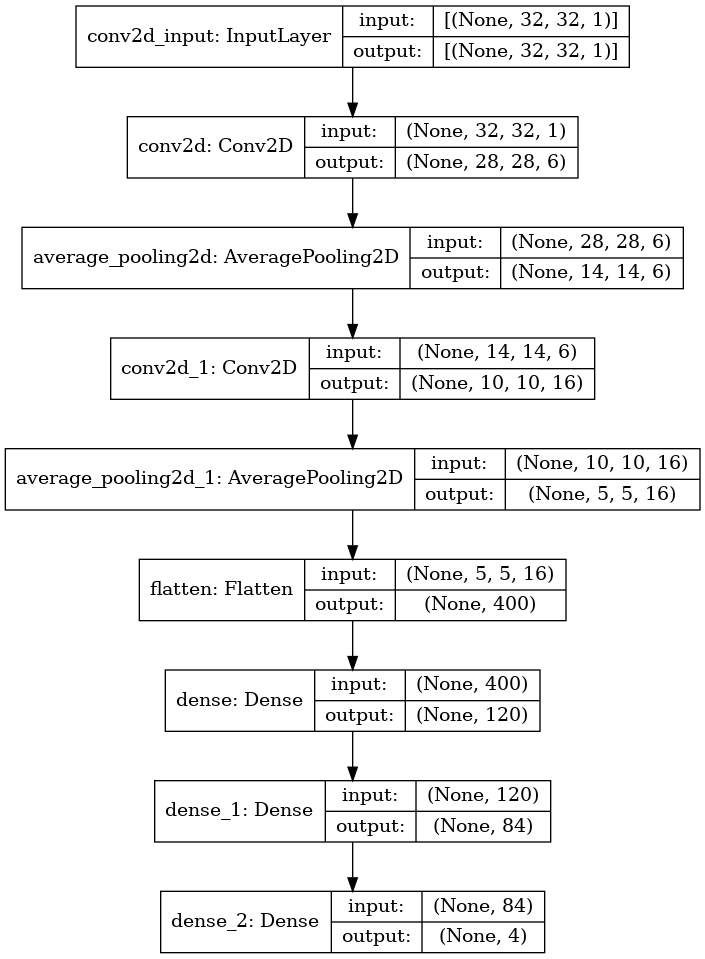

In [15]:
import tensorflow as tf
tf.keras.utils.plot_model(model, './ret_model.png', show_shapes = True)

In [18]:
checkp = tf.keras.callbacks.ModelCheckpoint('./ret_model.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)
history = model.fit(train_gen.flow(X_train, y_train), epochs = 20, validation_data = (X_valid, y_valid), callbacks = [checkp])

Epoch 1/20
626/626 [==============================] - 10s 16ms/step - loss: 1.0902 - accuracy: 0.5227 - val_loss: 0.9083 - val_accuracy: 0.6875

Epoch 00001: val_loss improved from inf to 0.90834, saving model to ./ret_model.h5
Epoch 2/20
626/626 [==============================] - 11s 17ms/step - loss: 1.0720 - accuracy: 0.5310 - val_loss: 0.8631 - val_accuracy: 0.6875

Epoch 00002: val_loss improved from 0.90834 to 0.86308, saving model to ./ret_model.h5
Epoch 3/20
626/626 [==============================] - 10s 16ms/step - loss: 1.0553 - accuracy: 0.5452 - val_loss: 0.8374 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 0.86308 to 0.83740, saving model to ./ret_model.h5
Epoch 4/20
626/626 [==============================] - 11s 17ms/step - loss: 1.0389 - accuracy: 0.5530 - val_loss: 0.8650 - val_accuracy: 0.7500

Epoch 00004: val_loss did not improve from 0.83740
Epoch 5/20
626/626 [==============================] - 10s 16ms/step - loss: 1.0179 - accuracy: 0.5648 - val_loss

Text(0, 0.5, 'Losses')

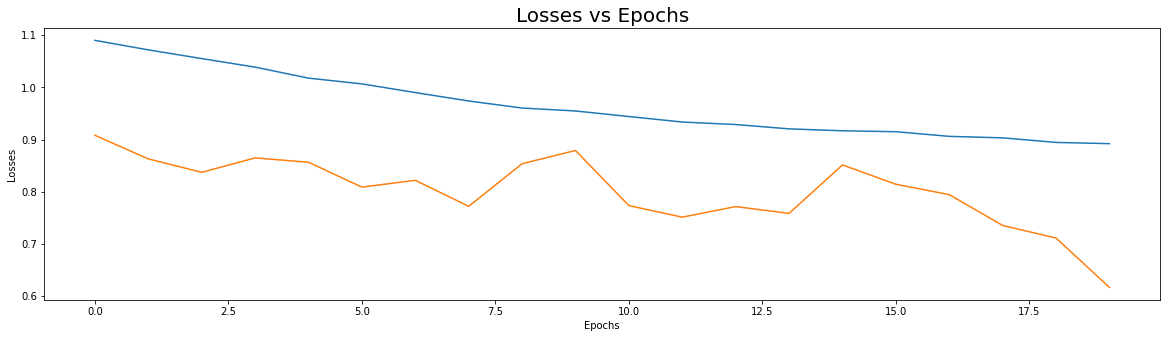

In [19]:
plt.figure(figsize = (20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Losses vs Epochs', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Losses')

Text(0, 0.5, 'Accuracy')

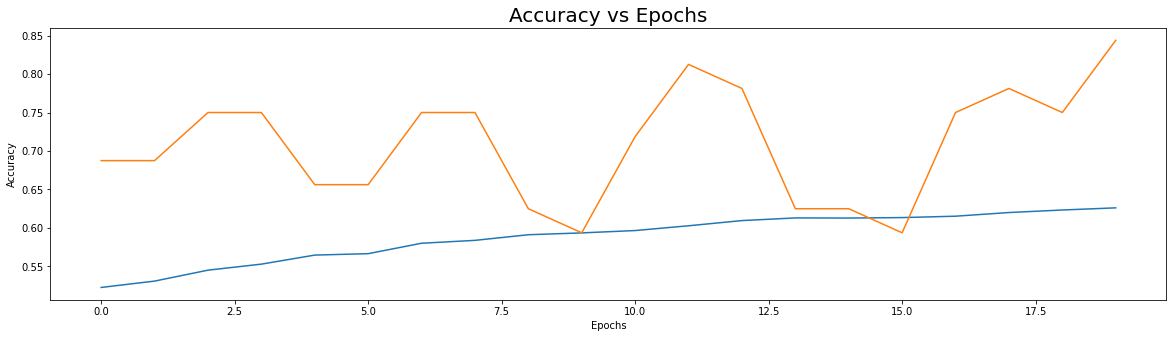

In [20]:
plt.figure(figsize = (20,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [21]:
val_acc=history.history['val_accuracy']
acc=history.history['accuracy']
print("\nValue Accuracy | ",round(val_acc[len(acc)-1]*100,2),'%')


Value Accuracy |  84.38 %


{'Class': 'NORMAL', 'Probability': 2}


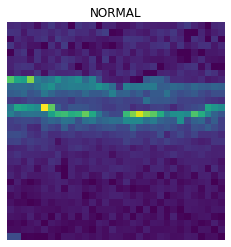

In [27]:
class_dict = {'DRUSEN':0,'CNV':1,'NORMAL':2,'DME':3}
class_names=list(class_dict.keys())
from keras.preprocessing import image
new_img=image.load_img("../input/kermany2018/OCT2017 /train/NORMAL/NORMAL-100580-5.jpeg",grayscale=True,target_size=(32,32))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255
predict_x=model.predict(img) 
img_class=np.argmax(predict_x,axis=1)
img_class_index = img_class.item() #extracting value(s)
classname = class_names[img_class_index]
predict_prob=model.predict(img)
img_prob=np.argmax(predict_prob,axis=1)
prediction_prob = img_prob.max()
pred_dict = {"Class":classname, "Probability":prediction_prob}
print(pred_dict)
#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

{'Class': 'DRUSEN', 'Probability': 0}


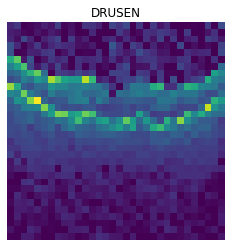

In [28]:
class_dict = {'DRUSEN':0,'CNV':1,'NORMAL':2,'DME':3}
from keras.preprocessing import image
new_img=image.load_img("../input/kermany2018/OCT2017 /val/DRUSEN/DRUSEN-9884539-1.jpeg",grayscale=True,target_size=(32,32))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255
predict_x=model.predict(img) 
img_class=np.argmax(predict_x,axis=1)
img_class_index = img_class.item() #extracting value(s)
classname = class_names[img_class_index]
predict_prob=model.predict(img)
img_prob=np.argmax(predict_prob,axis=1)
prediction_prob = img_prob.max()
pred_dict = {"Class":classname, "Probability":prediction_prob}
print(pred_dict)
#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

{'Class': 'DME', 'Probability': 3}


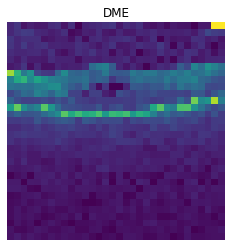

In [29]:
class_dict = {'DRUSEN':0,'CNV':1,'NORMAL':2,'DME':3}
from keras.preprocessing import image
new_img=image.load_img("../input/kermany2018/OCT2017 /val/DME/DME-9603124-1.jpeg",grayscale=True,target_size=(32,32))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255
predict_x=model.predict(img) 
img_class=np.argmax(predict_x,axis=1)
img_class_index = img_class.item() #extracting value(s)
classname = class_names[img_class_index]
predict_prob=model.predict(img)
img_prob=np.argmax(predict_prob,axis=1)
prediction_prob = img_prob.max()
pred_dict = {"Class":classname, "Probability":prediction_prob}
print(pred_dict)
#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

{'Class': 'CNV', 'Probability': 1}


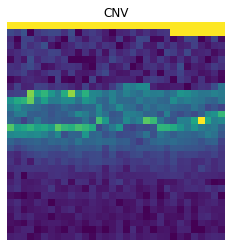

In [30]:
class_dict = {'DRUSEN':0,'CNV':1,'NORMAL':2,'DME':3}
from keras.preprocessing import image
new_img=image.load_img("../input/kermany2018/OCT2017 /val/CNV/CNV-6652117-1.jpeg",grayscale=True,target_size=(32,32))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255
predict_x=model.predict(img) 
img_class=np.argmax(predict_x,axis=1)
img_class_index = img_class.item() #extracting value(s)
classname = class_names[img_class_index]
predict_prob=model.predict(img)
img_prob=np.argmax(predict_prob,axis=1)
prediction_prob = img_prob.max()
pred_dict = {"Class":classname, "Probability":prediction_prob}
print(pred_dict)
#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, Y_pred))

Confusion Matrix
[[159  11  64   8]
 [ 19 204   1  18]
 [ 50   1 189   2]
 [ 31   9  30 172]]


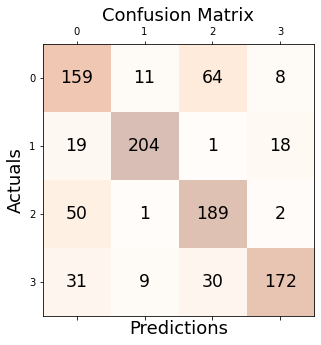

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_matrix(y_test_arg, Y_pred), cmap=plt.cm.Oranges, alpha=0.3)
for i in range(confusion_matrix(y_test_arg, Y_pred).shape[0]):
    for j in range(confusion_matrix(y_test_arg, Y_pred).shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix(y_test_arg, Y_pred)[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [48]:
from sklearn.metrics import classification_report

label_names = ['DRUSEN','CNV','NORMAL','DME']

print(classification_report(y_test_arg, Y_pred,target_names=label_names))

              precision    recall  f1-score   support

      DRUSEN       0.61      0.66      0.63       242
         CNV       0.91      0.84      0.87       242
      NORMAL       0.67      0.78      0.72       242
         DME       0.86      0.71      0.78       242

    accuracy                           0.75       968
   macro avg       0.76      0.75      0.75       968
weighted avg       0.76      0.75      0.75       968



In [58]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test_arg)==l,
                                                      np.array(Y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.862259,0.657025
1,1,0.971074,0.842975
2,2,0.869146,0.780992
3,3,0.961433,0.710744


In [52]:
model.save('./ret_model.h5')